In [16]:
#Importing libraries we'll work with
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [17]:
#loading the data into a dataframe
data = pd.read_csv('ResumeNames.csv')
print(data.head())

   rownames     name  gender ethnicity quality call     city  jobs  \
0         1  Allison  female      cauc     low   no  chicago     2   
1         2  Kristen  female      cauc    high   no  chicago     3   
2         3  Lakisha  female      afam     low   no  chicago     1   
3         4  Latonya  female      afam    high   no  chicago     4   
4         5   Carrie  female      cauc    high   no  chicago     3   

   experience honors  ... minimum equal      wanted requirements reqexp  \
0           6     no  ...       5   yes  supervisor          yes    yes   
1           6     no  ...       5   yes  supervisor          yes    yes   
2           6     no  ...       5   yes  supervisor          yes    yes   
3           6     no  ...       5   yes  supervisor          yes    yes   
4          22     no  ...    some   yes   secretary          yes    yes   

  reqcomm reqeduc reqcomp reqorg                          industry  
0      no      no     yes     no                     manufa

In [18]:
#get an idea of what the data looks like
print(data.head())
print(data.info())
print(data.isnull().sum())

   rownames     name  gender ethnicity quality call     city  jobs  \
0         1  Allison  female      cauc     low   no  chicago     2   
1         2  Kristen  female      cauc    high   no  chicago     3   
2         3  Lakisha  female      afam     low   no  chicago     1   
3         4  Latonya  female      afam    high   no  chicago     4   
4         5   Carrie  female      cauc    high   no  chicago     3   

   experience honors  ... minimum equal      wanted requirements reqexp  \
0           6     no  ...       5   yes  supervisor          yes    yes   
1           6     no  ...       5   yes  supervisor          yes    yes   
2           6     no  ...       5   yes  supervisor          yes    yes   
3           6     no  ...       5   yes  supervisor          yes    yes   
4          22     no  ...    some   yes   secretary          yes    yes   

  reqcomm reqeduc reqcomp reqorg                          industry  
0      no      no     yes     no                     manufa

In [19]:
#first we will find the basic relationship between name origin and hire rate
print(data[['ethnicity', 'call']].value_counts())
print(data[['ethnicity', 'call']].groupby('ethnicity').count())
#the "call" column contains yes and no depending on whether an applicate got a call, we need to convert string to 0,1 

data['call_numeric'] = data['call'].map({'yes': 1, 'no': 0})

# Calculate the overall callback rate
callback_rate = data['call_numeric'].mean()
print(f"Overall Callback Rate: {callback_rate:.2%}")



ethnicity  call
afam       no      2278
cauc       no      2200
           yes      235
afam       yes      157
Name: count, dtype: int64
           call
ethnicity      
afam       2435
cauc       2435
Overall Callback Rate: 8.05%


In [20]:
#Once we have the overall callrate we see the relationship between ethnicities
callback_by_ethnicity = data.groupby('ethnicity')['call_numeric'].mean()
print(callback_by_ethnicity)

ethnicity
afam    0.064476
cauc    0.096509
Name: call_numeric, dtype: float64


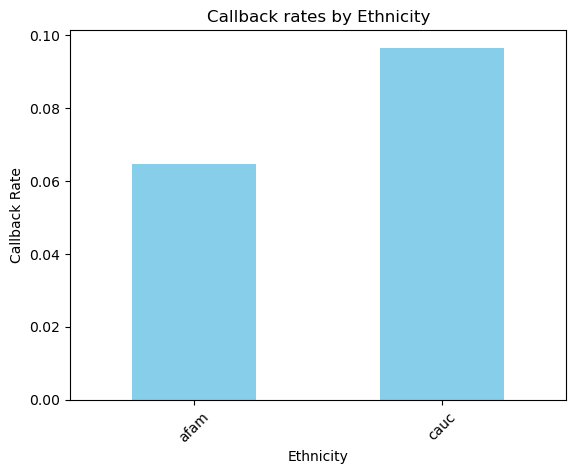

In [21]:
#we now have our averages but this doesn't tell us much lets plot it visually using matplotlib
callback_by_ethnicity.plot(kind='bar', color='skyblue')
plt.title('Callback rates by Ethnicity')
plt.xlabel('Ethnicity')
plt.ylabel('Callback Rate')
plt.xticks(rotation=45)
plt.show()

We now have a basic plot and we can see a difference between africa american sounding names and caucasain sounding names
However, is it significant or just random chance? To check we will use chi-square testing

In [22]:

contingency_table = pd.crosstab(data['ethnicity'], data['call_numeric'])
chi2, p, dof,excepted = chi2_contingency(contingency_table)
print(f"Chi-squared: {chi2}")
print(f"P-value: {p}")

Chi-squared: 16.44902858418937
P-value: 4.997578389963255e-05


The P value is incredibly small, approximately 0.00004997578389963255!! We could possibly conclude that there is a correlation between the sound of a name and the rate at which a canditate is called back
However we have simply looked at two factor, perhaps there is more at play
lets analyse more features such as and plot them
starting with gender

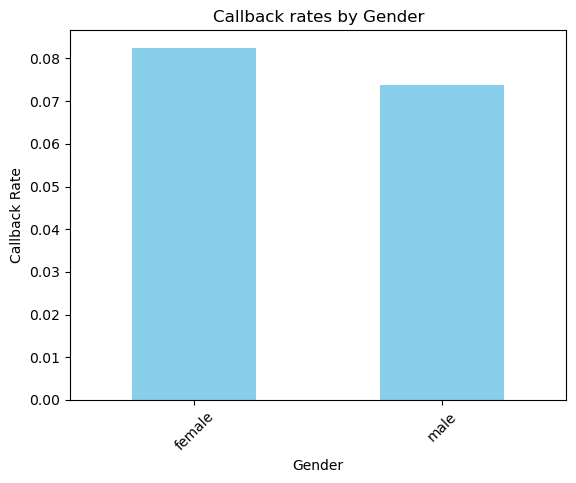

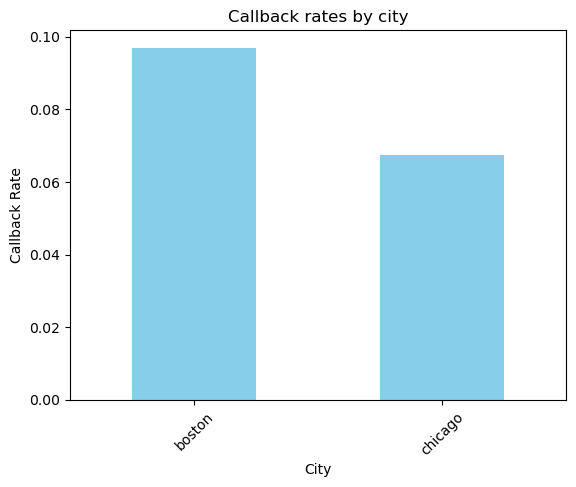

In [23]:

callback_by_gender = data.groupby('gender')['call_numeric'].mean()
callback_by_gender.plot(kind='bar', color='skyblue')
plt.title('Callback rates by Gender')
plt.xlabel('Gender')
plt.ylabel('Callback Rate')
plt.xticks(rotation=45)
plt.show()
#lets do city
callback_by_city = data.groupby('city')['call_numeric'].mean()
callback_by_city.plot(kind='bar', color='skyblue')
plt.title('Callback rates by city')
plt.xlabel('City')
plt.ylabel('Callback Rate')
plt.xticks(rotation=45)
plt.show()

What is actually quite interesting is that females actually receive a higher callback rate than males which is against the gender disequality narative
There is something to be examined, perhaps males experince a disadvantage of an ethnic name whereas woman do not, lets test this

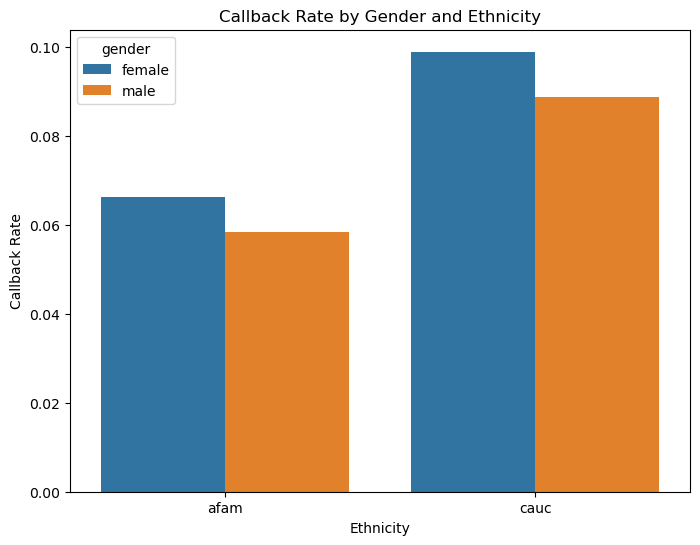

In [24]:


#We can first plot the two genders by ethnicity to get an idea
gender_ethnicity_group = data.groupby(['gender', 'ethnicity'])['call_numeric'].mean().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(x='ethnicity', y='call_numeric', hue='gender', data=gender_ethnicity_group)
plt.title('Callback Rate by Gender and Ethnicity')
plt.xlabel('Ethnicity')
plt.ylabel('Callback Rate')
plt.show()


In [25]:
#Lets first see if experince and quality of resume plays a role
gender_summary = data.groupby('gender')[['experience', 'quality']].describe()
print(gender_summary)



       experience                                               
            count      mean       std  min  25%  50%   75%   max
gender                                                          
female     3746.0  7.936733  4.998211  1.0  5.0  6.0  10.0  44.0
male       1124.0  7.530249  5.186287  1.0  5.0  7.0   8.0  26.0


We see that males have a higher mean for experince in fields
Lets get a fuller picture, we will use logistic regression to build a model to evalute different features of the data focusing currently on gender and ethnicity.

In [26]:
#for simplicity lets drop rows where we have incomplete data 
data.dropna(subset=['quality', 'experience', 'gender', 'ethnicity', 'call_numeric'], inplace=True)
#converts the gender column from an object of male and female to a label of 0 and 1 
le_gender = LabelEncoder()
data['gender_male'] = le_gender.fit_transform(data['gender'])  # 0: female, 1: male
#do the same for the ethnicity column
le_ethnicity = LabelEncoder()
data['ethnicity_cauc'] = le_ethnicity.fit_transform(data['ethnicity'])  # 0: non-caucasian, 1: caucasian
#we can now map different features to 0 and 1 to train the model
quality_mapping = {'low': 0, 'high': 1}
data['quality'] = data['quality'].map(quality_mapping)
military_mapping = {'no': 0, 'yes': 1}
data['military'] = data['military'].map(military_mapping)
holes_mapping = {'no': 0, "yes": 1}
college_mapping = {'no': 0, 'yes': 1}
data['college'] = data['college'].map(college_mapping)
data['holes'] = data['holes'].map(holes_mapping)
X = data[['experience', 'gender_male', 'ethnicity_cauc', 'quality', 'college']]

# Add a constant to the independent variables (for intercept in logistic regression)
X = sm.add_constant(X)

# The dependent variable (y) is 'call_numeric'
y = data['call_numeric']

# Step 4: Fit the logistic regression model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Step 5: Output the model summary
print(result.summary())



Optimization terminated successfully.
         Current function value: 0.276213
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           call_numeric   No. Observations:                 4870
Model:                          Logit   Df Residuals:                     4864
Method:                           MLE   Df Model:                            5
Date:                Tue, 11 Feb 2025   Pseudo R-squ.:                 0.01342
Time:                        13:20:05   Log-Likelihood:                -1345.2
converged:                       True   LL-Null:                       -1363.5
Covariance Type:            nonrobust   LLR p-value:                 7.185e-07
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.0238      0.154    -19.595      0.000      -3.326      -2.721
experience       

Optimization terminated successfully.
         Current function value: 0.276213
         Iterations 7
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           call_numeric   No. Observations:                 4870
Model:                          Logit   Df Residuals:                     4864
Method:                           MLE   Df Model:                            5
Date:                Thu, 02 Jan 2025   Pseudo R-squ.:                 0.01342
Time:                        18:20:16   Log-Likelihood:                -1345.2
converged:                       True   LL-Null:                       -1363.5
Covariance Type:            nonrobust   LLR p-value:                 7.185e-07
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.0238      0.154    -19.595      0.000      -3.326      -2.721
experience         0.0376      0.009      4.047      0.000       0.019       0.056
gender_male       -0.1064      0.132     -0.807      0.420      -0.365       0.152
ethnicity_cauc     0.4399      0.108      4.089      0.000       0.229       0.651
quality            0.1531      0.107      1.436      0.151      -0.056       0.362
college           -0.0277      0.119     -0.232      0.816      -0.261       0.206
==================================================================================

We now have a function model, however this doesn't help us and isn't easy to understand so lets visualize it

C:\Users\vente\AppData\Local\Temp\ipykernel_13536\1910663668.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Odds Ratio', y='Variable', data=odds_ratios_data, palette='coolwarm')


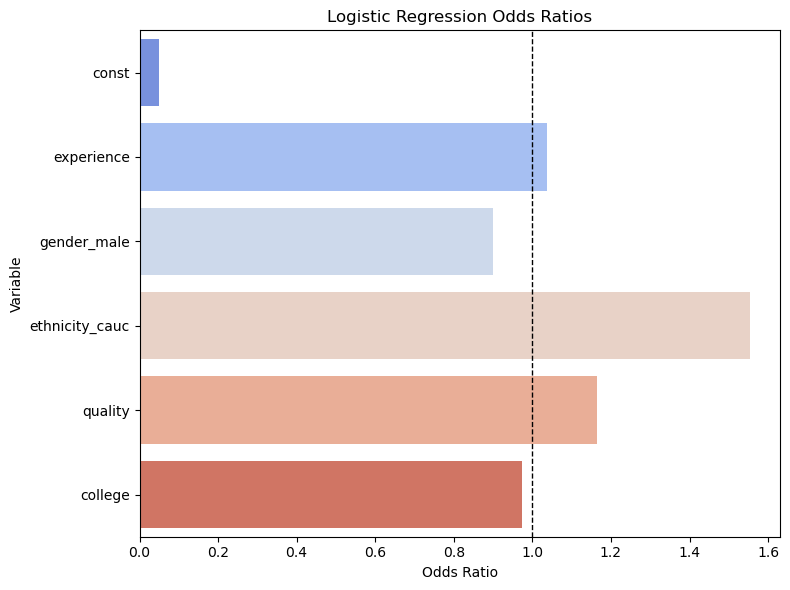

In [27]:
coefficients = result.params
odds_ratios = np.exp(coefficients)

# Prepares the data for plotting
odds_ratios_data = pd.DataFrame({
    'Variable': odds_ratios.index,
    'Odds Ratio': odds_ratios.values
})

# Sets the figure size for the plot
plt.figure(figsize=(8, 6))

# Plots the odds ratios
sns.barplot(x='Odds Ratio', y='Variable', data=odds_ratios_data, palette='coolwarm')

# Adds a vertical line at 1 for better interpretation (values >1 increase odds, <1 decrease odds)
plt.axvline(x=1, color='black', linestyle='--', linewidth=1)

# Title and labels
plt.title('Logistic Regression Odds Ratios')
plt.xlabel('Odds Ratio')
plt.ylabel('Variable')

# Show plot
plt.tight_layout()
plt.show()


As we can see from our model, having an ethnically white sounding name is actually the most important factor that affects the odds of getting a call back. 

Lastly I wanted to identify which industries were most guilty of this practice.

In [28]:
#lets create a pivot table to show this
callback_pivot = pd.pivot_table(
    data,
    index='industry',
    columns='ethnicity_cauc',
    values='call_numeric',
    aggfunc='mean'
)
print(callback_pivot.head())

ethnicity_cauc                           0         1
industry                                            
business/personal services        0.062883  0.104294
finance/insurance/real estate     0.043478  0.101449
health/education/social services  0.092838  0.114058
manufacturing                     0.039604  0.069307
trade                             0.051823  0.086372


ethnicity_cauc                           0         1
industry                                            
business/personal services        0.062883  0.104294
finance/insurance/real estate     0.043478  0.101449
health/education/social services  0.092838  0.114058
manufacturing                     0.039604  0.069307
trade                             0.051823  0.086372

Lets again visualize this to understand it better

<Figure size 1200x600 with 0 Axes>

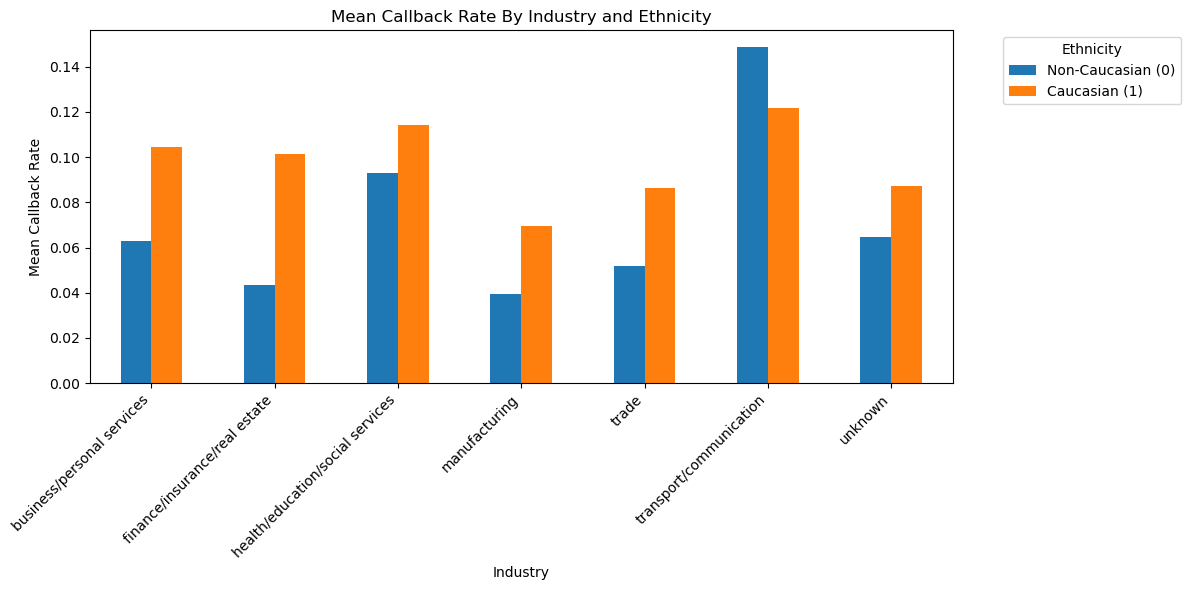

In [29]:
#converts the pivot table back to a dataframe to be plotted
callback_pivot = callback_pivot.reset_index()

#plotting
plt.figure(figsize=(12,6))
callback_pivot.plot(
    x='industry',
    kind='bar',
    figsize=(12,6)
)
plt.title('Mean Callback Rate By Industry and Ethnicity')
plt.xlabel('Industry')
plt.ylabel('Mean Callback Rate')
plt.xticks(rotation=45, ha='right')
plt.legend(['Non-Caucasian (0)', 'Caucasian (1)'], title= 'Ethnicity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()